In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pandas_datareader.data as web
import pickle 
import requests
import tensorflow as tf

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [2]:
image_path = 'D:/kenneth/agent/images/'
ticker = '^GSPC'
start=('2019-01-01')
end=('2019-12-31')
# df=web.DataReader(ticker,'yahoo',start,end)
# df.to_csv(ticker+'.csv')
df = pd.read_csv('D:/kenneth/agent/'+ticker+'.csv', index_col=0, parse_dates=True)

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy

## Evolution Strategy agent

In [3]:
import pkg_resources
import types


name = 'Evolution Strategy agent'


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

tensorflow==1.10.0
seaborn==0.9.0
requests==2.19.1
pandas==0.23.4
numpy==1.17.2
matplotlib==2.2.3


In [4]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [6]:
import time
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 17.521985
iter 20. reward: 21.534082
iter 30. reward: 25.702383
iter 40. reward: 26.218479
iter 50. reward: 27.408982
iter 60. reward: 26.920583
iter 70. reward: 25.861382
iter 80. reward: 27.128579
iter 90. reward: 27.991582
iter 100. reward: 28.084480
iter 110. reward: 28.685388
iter 120. reward: 28.157483
iter 130. reward: 28.332485
iter 140. reward: 29.038784
iter 150. reward: 28.892683
iter 160. reward: 29.489182
iter 170. reward: 29.432285
iter 180. reward: 29.641384
iter 190. reward: 30.216289
iter 200. reward: 30.765891
iter 210. reward: 30.336089
iter 220. reward: 30.726394
iter 230. reward: 30.454390
iter 240. reward: 29.923789
iter 250. reward: 29.917791
iter 260. reward: 30.683489
iter 270. reward: 30.679993
iter 280. reward: 30.496787
iter 290. reward: 30.671389
iter 300. reward: 30.200784
iter 310. reward: 30.565291
iter 320. reward: 28.896287
iter 330. reward: 29.893291
iter 340. reward: 29.787390
iter 350. reward: 30.600793
iter 360. reward: 30.172092
i

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 1: buy 1 unit at price 2447.889893, total balance 7552.110107
day 3: buy 1 unit at price 2549.689941, total balance 5002.420166
day 4: buy 1 unit at price 2574.409912, total balance 2428.010254
day 7, sell 1 unit at price 2596.260010, investment 6.061143 %, total balance 5024.270264,
day 8: buy 1 unit at price 2582.610107, total balance 2441.660156
day 12, sell 1 unit at price 2670.709961, investment 4.746460 %, total balance 5112.370117,
day 13: buy 1 unit at price 2632.899902, total balance 2479.470215
day 14, sell 1 unit at price 2638.699951, investment 2.497273 %, total balance 5118.170166,
day 15: buy 1 unit at price 2642.330078, total balance 2475.840088
day 16, sell 1 unit at price 2664.760010, investment 3.180887 %, total balance 5140.600098,
day 17: buy 1 unit at price 2643.850098, total balance 2496.750000
day 22, sell 1 unit at price 2724.870117, investment 3.493115 %, total balance 5221.620117,
day 24, sell 1 unit at price 2731.610107, investment 3.378837 %, total balan

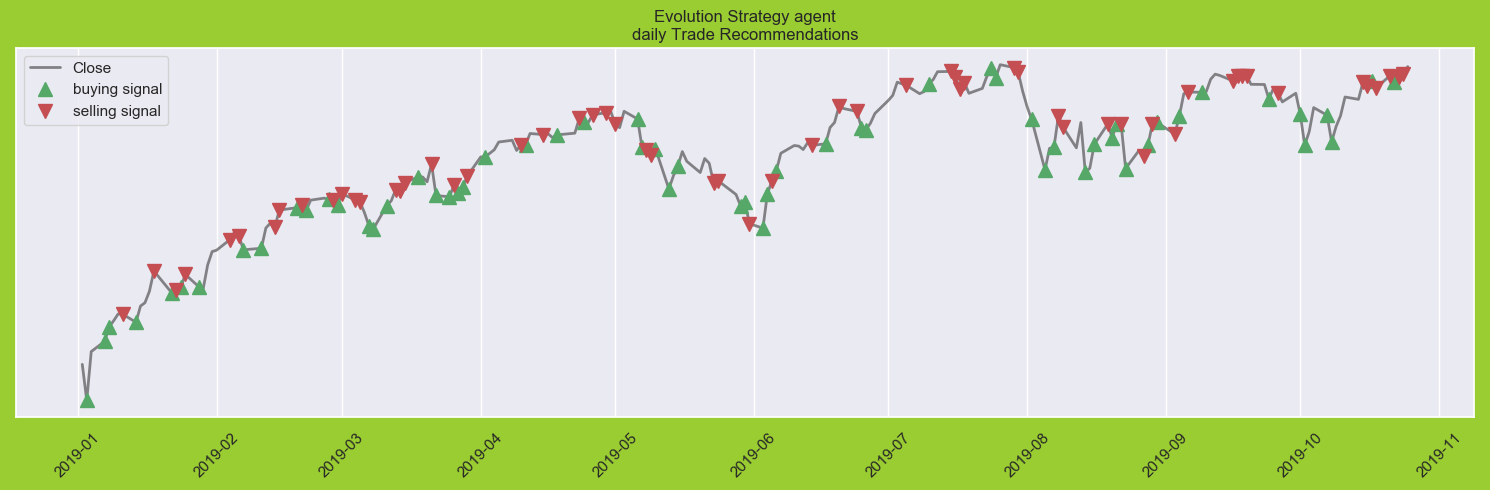

In [8]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=2., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()

In [9]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [10]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[6, 11, 12, 15, 16, 23, 26]

In [11]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[1, 2, 3, 8, 21, 22, 24, 25, 27, 28]

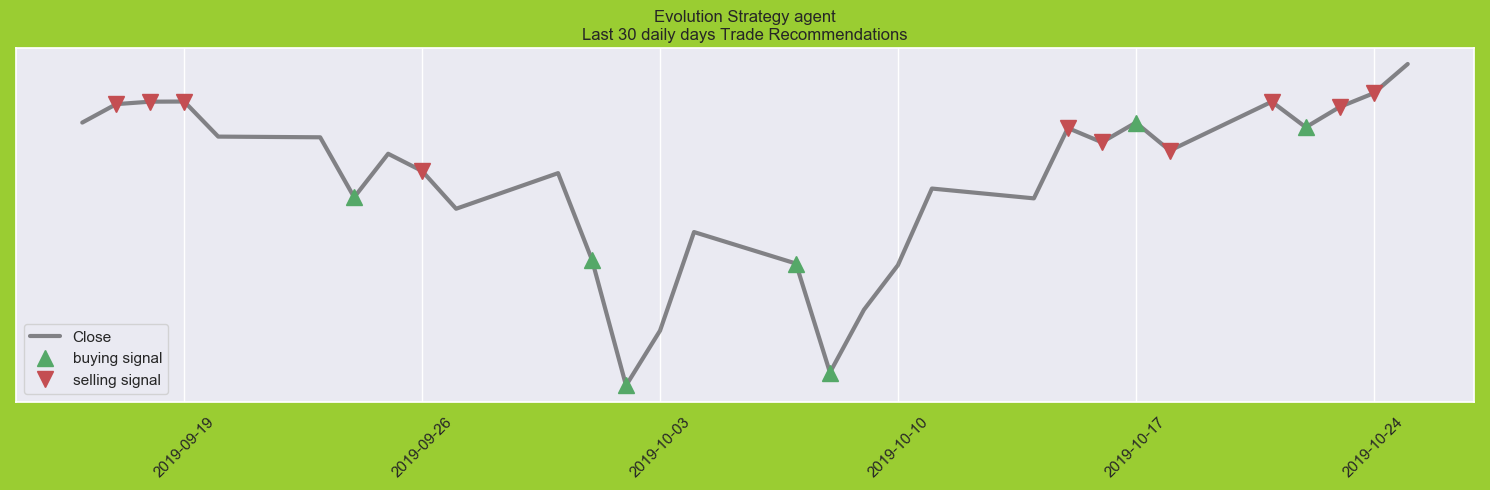

In [12]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' daily days Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()